In [2]:
# import minirats 
from minirats.HaloFinder.py.haloCatalog import haloCatalog as hC
from minirats.utils.py.cellutils import py_cell_utils as cu
from minirats.utils.py.f90utils import star_utils as SU

# other imports 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.io import FortranFile
import h5py, os

# constants 
h_cgs     = 6.6260755e-27  # [erg s]
clight    = 2.99792458e10  # [cm/s]
erg2Ryd   = 1. / 2.17987e-11 

In [3]:
vect = np.array([2.1e-5,3.5e-6,1.1e-5]*1000000,dtype='float64')
a = 2.19823

In [4]:
b = vect*(1+a)
print(b)

[6.7162830e-05 1.1193805e-05 3.5180530e-05 ... 6.7162830e-05 1.1193805e-05
 3.5180530e-05]


In [5]:
#CHANGEMENT!!!!!!!!!!!!!!!!!!!!
# Function taken fron ramses utils, by Trebitsch & Rosdahl.
def readRamsesSEDs(sedDir):
    """Read SED in ramses format and return
    Parameters:
    ----------------------------------------------------------------------
    sedDir: Directory containing the SED tables
    """
    # Read metallicity bins
    ZFile = open(sedDir+'/metallicity_bins.dat', 'r')
    nZ = eval(ZFile.readline())
    ZBins = []
    for Z in range(0,nZ): ZBins.append(eval(ZFile.readline()))
    ZFile.close()

    # Read age bins
    ageFile = open(sedDir+'/age_bins.dat', 'r')
    nAge = eval(ageFile.readline())
    ageBins = []
    for age in range(0,nAge): ageBins.append(eval(ageFile.readline()))
    ageFile.close()

    # Read wavelength bins and spectra
    # spectra are in [Lsun / A / Msun]
    # with Lsun = 3.826e33 erg/s and Msun = 2e33g
    sedFile = FortranFile(sedDir+'/all_seds.dat','r')
    nLambda = sedFile.read_ints()[0]
    lambdaBins = sedFile.read_reals()
    spectra = np.empty([nLambda,nAge,nZ])
    for iZ in range(0,nZ):
        for iAge in range(0,nAge):
            spectrum = sedFile.read_reals()
            spectra[:,iAge,iZ] = spectrum  

    Lsun_cgs = 3.826e33
    Msun_cgs = 2e33
    return {'ZBins':ZBins, 'ageBins':ageBins, 'lambdaBins':lambdaBins,'spectra':spectra,'Lsun_cgs':Lsun_cgs,'Msun_cgs':Msun_cgs}

def get_iage_iZ(Z,age,Zbins,agebins):
    # interpolation weigths in Z 
    if Z <= Zbins[0]:
        iz1 = 0
        wz1 = 1.0 # full weight to iz1 (and zero to iz1+1)
    elif Z >= Zbins[-1]:
        iz1 = len(Zbins)-2
        wz1 = 0.0 # no weight to iz1 (and full weight to iz1+1)
    else:
        iz1 = 0
        while (Z >= Zbins[iz1+1]):
            iz1 = iz1 + 1
        # Z is between Zbins[iz1] and Zbins[iz1+1]
        wz1 = (Zbins[iz1+1] - Z) / (Zbins[iz1+1]-Zbins[iz1])
    # interpolation weights in age
    if age <= agebins[0]:
        ia1 = 0
        wa1 = 1.0 # full weight to ia1 (and zero to ia1+1)
    elif age >= agebins[-1]:
        ia1 = len(agebins)-2
        wa1 = 0.0 # no weight to ia1 (and full weight to ia1+1)
    else:
        ia1 = 0
        while (age >= agebins[ia1+1]):
            ia1 = ia1 + 1
        # age is between agebins[ia1-1] and agebins[ia1]
        wa1 = (agebins[ia1+1] - age)/(agebins[ia1+1]-agebins[ia1])
    return iz1,wz1,ia1,wa1


def h5_read_stars(filename):
    f = h5py.File(filename,'r')
    star_mass = f['star_mass'][:]
    star_x = f['star_x'][:]
    star_y = f['star_y'][:]
    star_z = f['star_z'][:]
    star_id = f['star_id'][:]
    star_age = f['star_age'][:]
    star_vx = f['star_vx'][:]
    star_vy = f['star_vy'][:]
    star_vz = f['star_vz'][:]
    star_mets = f['star_mets'][:]
    star_minit = f['star_minit'][:]
    f.close()
    return star_mass,star_x,star_y,star_z,star_id,star_age,star_vx,star_vy,star_vz,star_mets,star_minit

def h5_read_cells(filename):
    f = h5py.File(filename,'r')
    cells = f["cells"][:,:]
    if 'rt' not in filename:
        cell_pos = f["cell_pos"][:,:]
        cell_l = f["cell_l"][:]
        f.close()
        return cells,cell_pos,cell_l
    else:
        f.close()
        return cells


In [6]:
# define a halo catalog object
RamsesDir = '/Users/mauerhof/Documents/RamsesFiles/SIMULATIONS/P13-20h-1Mpc-MUSIC/Zoom-7-10508/SPHINX_run/' #'/scratch/blaizot/sphinx/05_F1000/02_IC20_BP/'
timestep  = 137  # 183
#RamsesDir = '/Users/blaizot/Documents/Astro/SIMULATIONS/P13-20h-1Mpc-MUSIC/Zoom-7-10508/SPHINX_run/' #'/scratch/blaizot/sphinx/05_F1000/02_IC20_BP/'
#timestep  = 30 #148  # 183
readFromRamsesOutput = False 

hcat = hC(RamsesDir,timestep,HaloDir='Halos/',zoom=True)


In [7]:
# load the halo catalog 
hcat.load_catalog()
hcat.convert_distances() # convert positions and sizes to code units (store in xxxx_cu variables)

In [8]:
# select a halo 
hmain = np.where((hcat.level==1) &(hcat.contam < 0.5) &(hcat.mvir > 4e7*1e-11))[0]
myhalo = hmain[np.where(hcat.mvir[hmain]==max(hcat.mvir[hmain]))[0][0]]
center = [hcat.x_cu[myhalo],hcat.y_cu[myhalo],hcat.z_cu[myhalo]]
radius = 1.2*hcat.rvir_cu[myhalo]


## Definition de la forme spectrale dans chaque bin
On utilise le spectre de l'ensemble des étoiles du halo 

In [9]:
# Read SSP spectra from sedDir 
ssp = readRamsesSEDs('/Users/mauerhof/Documents/seds/bpass100/')
ssp.keys()

dict_keys(['ZBins', 'ageBins', 'lambdaBins', 'spectra', 'Lsun_cgs', 'Msun_cgs'])

In [10]:
#CHANGEMENT !!!!!!!!!!!!!
# read the star particles ... 
if readFromRamsesOutput:
    nstars = SU.get_tot_nstars(RamsesDir,timestep)   # get nb of star particles in the output
    star_mass,star_x,star_y,star_z,star_id,star_age,star_vx,star_vy,star_vz,star_mets,star_minit = SU.read_stars_all_props(RamsesDir,timestep,nstars,True,age_conv=True)
else:
    h5CellFile = '%s/Halos/%5.5i/stars.h5'%(RamsesDir,timestep)
    star_mass,star_x,star_y,star_z,star_id,star_age,star_vx,star_vy,star_vz,star_mets,star_minit = h5_read_stars(h5CellFile)


In [11]:
# select star particles in the halo 
d2 = (star_x-center[0])**2 + (star_y-center[1])**2 + (star_z-center[2])**2
ii = np.where(d2 < radius*radius)[0]
star_mass,star_x,star_y,star_z,star_id,star_age,star_vx,star_vy,star_vz,star_mets,star_minit = \
    star_mass[ii],star_x[ii],star_y[ii],star_z[ii],star_id[ii],star_age[ii],star_vx[ii],\
    star_vy[ii],star_vz[ii],star_mets[ii],star_minit[ii]
# convert ages to yr 
star_age = star_age * 1e6 # [yr]
# convert mass to Msun 
star_minit = star_minit * (hcat.info['unit_d'] * hcat.info['unit_l']**3 / ssp['Msun_cgs'])  # [Msun]

In [12]:
#CHANGEMENT!!!!!!!!!!!!!!!!!!!!
# compute weight of each SED in the full spectrum 
weights = np.zeros((len(ssp['ZBins']),len(ssp['ageBins'])))
for age,Z,m in zip(star_age,star_mets,star_minit):
    iz,wz,ia,wa        = get_iage_iZ(Z,age,ssp['ZBins'],ssp['ageBins'])
    weights[iz,ia]     = weights[iz,ia]     + wz*wa * m
    weights[iz+1,ia]   = weights[iz+1,ia]   + (1-wz)*wa * m
    weights[iz,ia+1]   = weights[iz,ia+1]   + wz*(1-wa) * m
    weights[iz+1,ia+1] = weights[iz+1,ia+1] + (1-wz)*(1-wa) * m


In [13]:
# compute the full spectrum 
flux = np.zeros((len(ssp['lambdaBins'])))
for ia in range(len(ssp['ageBins'])):
    for iz in range(len(ssp['ZBins'])):
        flux = flux + ssp['spectra'][:,ia,iz] * weights[iz,ia]
flux = flux * ssp['Lsun_cgs'] # [erg/s/A]
flux = flux * ssp['lambdaBins'] * (ssp['lambdaBins']*1e-8) / clight # [erg/s/Hz]
ryds = h_cgs * clight / (ssp['lambdaBins']*1e-8) * erg2Ryd  # energy in Rydberg 
nus  = clight / (ssp['lambdaBins']*1e-8) # [Hz]


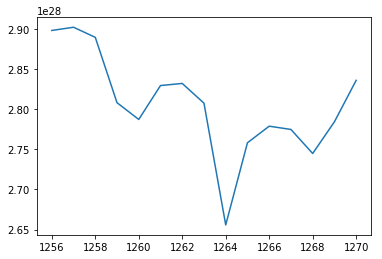

In [27]:
import matplotlib.pyplot as plt
# plt.plot(ryds, flux)
# plt.xlabel(r'$E$ [ryd]')
lambdas = clight/nus*1e8
nuFnu = flux*nus
lambdas_1260 = lambdas[(lambdas<1270)&(lambdas>1255)]
nuFnu_1260 = nuFnu[(lambdas<1270)&(lambdas>1255)]
flux_1260 = flux[(lambdas<1270)&(lambdas>1255)]
# plt.plot(lambdas,nuFnu)
plt.plot(lambdas_1260,flux_1260)
# plt.xlabel(r'$\lambda$ [A]')
# plt.yscale('log'); #plt.xscale('log')


In [34]:
# premier bin d'energie (<13.6eV == 1Ryd), etc
bin0 = np.where(ryds  <= 0.999469)[0]
f = open('runs/sedCloudy_grp0.sed','w')
for x,y in zip(reversed(ryds[bin0]),reversed(flux[bin0])):
    f.write("%.16e %.16e \n"%(x,y))
f.close()
bin1 = np.where((ryds > 0.999469)&(ryds<=1.807))[0]
f = open('runs/sedCloudy_grp1.sed','w')
for x,y in zip(reversed(ryds[bin1]),reversed(flux[bin1])):
    f.write("%.16e %.16e \n"%(x,y))
f.close()
bin2 = np.where((ryds > 1.807)   &(ryds<=3.9996))[0]
f = open('runs/sedCloudy_grp2.sed','w')
for x,y in zip(reversed(ryds[bin2]),reversed(flux[bin2])):
    f.write("%.16e %.16e \n"%(x,y))
f.close()
bin3 = np.where(ryds  > 3.9996)[0]
f = open('runs/sedCloudy_grp3.sed','w')
for x,y in zip(reversed(ryds[bin3]),reversed(flux[bin3])):
    f.write("%.16e %.16e \n"%(x,y))
f.close()


## normalisation des intensités à partir de l'output RAMSES 
- lire les cellules pour récupérer leurs propriétés _et_ le rayonnement 
- convertir Nphot [#/s/cm2] en L [erg/s/cm2]
- Mettre [nH, Z, J1, J2, J3, J4, T] dans un fichier d'input pour Cloudy


In [35]:
# read cells
if readFromRamsesOutput:
    lmax = -1 # read all levels 
    ncells = cu.count_cells(RamsesDir,timestep,lmax,center,radius)
    idens   = 1
    ivx,ivy,ivz=2,3,4
    ipre    = 5
    imet    = 6
    ixhii   = 7
    ixheii  = 8
    ixheiii = 9
    # RT fields
    iNp1,iNp2,iNp3 = 11,15,19
    readRT=True
    cells,cell_pos,cell_l = cu.read_cells_hydro(RamsesDir,timestep,lmax,ncells,
                                                              [idens,ipre,ixhii,ixheii,ixheiii,
                                                               ivx,ivy,ivz,imet,iNp1,iNp2,iNp3],
                                                              center,radius,readRT)
else:
    h5CellFile = '%s/Halos/%5.5i/cells.h5'%(RamsesDir,timestep)
    cells,cell_pos,cell_l = h5_read_cells(h5CellFile)
    h5CellFile = '%s/Halos/%5.5i/cells_rt.h5'%(RamsesDir,timestep)
    cells_rt = h5_read_cells(h5CellFile)


In [36]:
# get units for photons 
filename = "%s/output_%5.5i/info_rt_%5.5i.txt"%(RamsesDir,timestep,timestep)
f = open(filename,'r')
ls = f.readlines()
for i,l in enumerate(ls):
    if 'unit_pf' in l:
        unit_fp = float(l.split()[2])
    if 'Group 1' in l:
        csn1 = float(ls[i+2].split()[3])
    if 'Group 2' in l:
        csn2 = float(ls[i+2].split()[3])
    if 'Group 3' in l:
        csn3 = float(ls[i+2].split()[3])
f.close()


In [66]:
X_frac=0.76
Y_frac=0.24

if readFromRamsesOutput:
    Np1 = np.array(cells[:,9],dtype='float64') * unit_fp # [phot/s/cm2]
    Np2 = np.array(cells[:,10],dtype='float64') * unit_fp # [phot/s/cm2]
    Np3 = np.array(cells[:,11],dtype='float64') * unit_fp # [phot/s/cm2]
    rho    = np.array(cells[:,0],dtype='float64')
    pres   = np.array(cells[:,1],dtype='float64')
    xHII   = np.array(cells[:,2],dtype='float64')
    xHeII  = np.array(cells[:,3],dtype='float64')
    xHeIII = np.array(cells[:,4],dtype='float64')
    metallicity = np.array(cells[:,8],dtype='float64')
else:
    Np1 = np.array(cells_rt[:,0],dtype='float64') 
    Np1 = Np1 * unit_fp # [phot/s/cm2]
    Np2 = np.array(cells_rt[:,1],dtype='float64') 
    Np2 = Np2 * unit_fp # [phot/s/cm2]
    Np3 = np.array(cells_rt[:,2],dtype='float64') 
    Np3 = Np3 * unit_fp # [phot/s/cm2]
    rho    = np.array(cells[:,0],dtype='float64')
    pres   = np.array(cells[:,1],dtype='float64')
    xHII   = cells[:,2]#,dtype='float64')
    xHeII  = np.array(cells[:,3],dtype='float64')
    xHeIII = np.array(cells[:,4],dtype='float64')
    metallicity = np.array(cells[:,8],dtype='float64')

    
# nH   = rho * hcat.info['unit_nH']  # [ H / cm3 ]
# nHe  = 0.25*nH*(1.0-X_frac)/X_frac
# nHII = xHII*nH
# xHI  = 1.0 - xHII
# nHI  = nH*xHI 
mu   = np.divide(1,X_frac*(1.+xHII) + 0.25*(1.-X_frac)*(1.+xHeII+2.*xHeIII))
# mu   = 1./( X_frac*(1.+xHII) + 0.25*(1.-X_frac)*(1.+xHeII+2.*xHeIII) )
TK   = np.multiply( np.multiply( np.divide(pres,rho), mu), hcat.info['unit_T2'])  # [K]
    
# cell volume 
# cell_size_cm = 1./ 2.**cell_l * hcat.info['unit_l']
# cell_volume_cgs = cell_size_cm**3

In [38]:
print(xHII.size)

10176572


In [55]:
a = X_frac*(1+xHII)
print(a.dtype)
# print(X_frac.dtype)
print(a)

float64
[0.66724348 0.66724344 0.66724346 ... 0.66724311 0.66724307 0.66724305]


In [67]:
print(TK)

[1289607.50502624  784156.07275514  946265.61710797 ...  151377.88260973
  145754.81213939  142897.83801238]


In [77]:
print(unit_fp)
print(np.array(cells_rt[:,0],dtype='float64'))
a=np.array(cells_rt[:,0],dtype='float64')
b=a*unit_fp
print(b)
print(Np1)

72125851776.4272
[4.77102944e-07 5.78459639e-07 5.30310980e-07 ... 2.05391416e-07
 1.69903173e-07 1.31282464e-07]
[34411.45621888 41721.89419618 38249.13116744 ... 14814.03079824
 12254.41104623  9468.85956847]
[34411.45621888 41721.89419618 38249.13116744 ... 14814.03079824
 12254.41104623  9468.85956847]


In [73]:
print(Np1)
print(np.min(Np1),np.max(Np1))

[34411.45621888 41721.89419618 38249.13116744 ... 14814.03079824
 12254.41104623  9468.85956847]
3.1011764912737043e-40 479460356111.72845


In [ ]:
mu = np.zeros(nH.size)
TK = np.zeros(nH.size)
for i in range(nH.size):
    mu[i] = 1./( X_frac*(1.+xHII[i]) + 0.25*(1.-X_frac)*(1.+xHeII[i]+2.*xHeIII[i]) )
    TK[i] = pres[i]/rho[i]*mu[i]*hcat.info['unit_T2']  # [K]

In [36]:
# renormalisation des Np 
# Np = \int J_true / h nu dnu
# On veut J = \int J_true dnu == \int Jnorm dnu * Np / \int Jnorm/hnu dnu
# -> on doit calculer \int Jnorm/hnu dnu et \int Jnorm dnu
nu, Fnu = nus[bin1],flux[bin1]  # Jnorm ... 
J1_nphot = abs(np.trapz(Fnu/(h_cgs*nu), nu))
J1_int   = abs(np.trapz(Fnu,nu))
J1 = J1_int * Np1 / J1_nphot 
nu, Fnu = nus[bin2],flux[bin2]  # Jnorm ... 
J2_nphot = abs(np.trapz(Fnu/(h_cgs*nu), nu))
J2_int   = abs(np.trapz(Fnu,nu))
J2 = J2_int * Np2 / J2_nphot 
nu, Fnu = nus[bin3],flux[bin3]  # Jnorm ... 
J3_nphot = abs(np.trapz(Fnu/(h_cgs*nu), nu))
J3_int   = abs(np.trapz(Fnu,nu))
J3 = J3_int * Np3 / J3_nphot 

In [42]:
# DEVRAIT CHANGER ??
# continu non ionisant 
# 1/ Normalisation en fonction du continu ionisant... 
# J0 = \int Jnorm dnu, avec Jnorm[lmin du bin 0] = 0.1 * Jnorm[lmax du bin 0]
nu, Fnu = nus[bin0],flux[bin0]
J0_int = abs(np.trapz(Fnu, nu)) 
Frouge = flux[bin1[-1]] / J1_nphot *Np1
Fbleu  = Fnu[0]
# J0 = J0_int * (Frouge/Fbleu*10.)
J0 = np.zeros(nH.size)
for i in range(nH.size):
    J0[i] = J0_int * (Frouge[i]/Fbleu*10.)
# 2/ normalisation en supposant un champ de rayonnement uniforme ... 


In [43]:
print(J0)

[1.89021413e+17 2.29177496e+17 2.10101681e+17 ... 5.86910868e+27
 4.85502368e+27 3.75142773e+27]


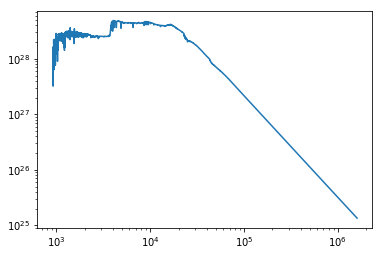

In [18]:
plt.plot(clight/nu*1e8,Fnu) ; plt.yscale('log'); plt.xscale('log')

## Ecriture des fichiers cloudy

### Exemple de fichier cloudy : 
```
print off
abundances GASS10
hden -4.66220468659738
element abundance helium -1.103
metals -0.9514740954897992 log
element limit off -5.951474095489799
table SED "sedCloudy_grp0.sed"
intensity linear total 1.3712477367263086e-06
table SED "sedCloudy_grp1.sed"
intensity linear total 4.4032852441277765e-07
table SED "sedCloudy_grp2.sed"
intensity linear total 2.8463214417601707e-07
table SED "sedCloudy_grp3.sed"
intensity linear total 4.882550068345575e-10
CMB z=3
const temp 6.109781217359563
sphere
iterate to convergence
stop zone 1
radius 30
no molecules
no H2 molecule
no induced processes
save last ionization means file = ".ionavr"
save lines, emissivity, emergent, last, ".lines"
H  1 1215.67A
H  1 4861.33A
H  1 6562.81A
N  5 1238.82A
N  5 1242.80A
C  3 1908.73A
C  4 1548.19A
C  4 1550.78A
He 2 1640.43A
O  2 3726.03A
O  2 3728.81A
O  3 1666.15A
O  3 4958.91A
O  3 5006.84A
Ne 3 3868.76A
S  2 6716.44A
S  2 6730.82A
end of lines
stop temperature off
set dr 0
```

In [19]:
class Line(object):
    def __init__(self,e,i,w):
        self.element    = e
        self.ion_state  = i
        self.wavelength = w
    def cloudyString(self):
        return "%s %i %.2fA"%(self.element,self.ion_state,self.wavelength)

In [31]:
# list of interesting lines 
lineList = [Line("H", 1, 1215.67),  # Lyman-alpha
            Line("H", 1, 4101.73),  # Hdelta
            Line("H", 1, 4340.46),  # Hgamma
            Line("H", 1, 4861.33),  # Hbeta
            Line("H", 1, 6562.81),  # Halpha
    
            Line("N", 2, 6548.05), 
            Line("N", 2, 6583.45),
            Line("N", 4, 1483.32),
            Line("N", 4, 1486.50),
            Line("N", 5, 1238.82),
            Line("N", 5, 1242.80),

            Line("C", 2, 1580000.),
            Line("C", 3, 1908.73),
            Line("C", 3, 1906.683),
            Line("C", 4, 1548.19),
            Line("C", 4, 1550.78),

            Line("He",2, 1640.43),

            Line("O", 1, 1302.17),
            Line("O", 1, 1304.86),
            Line("O", 1, 1306.03),
            Line("O", 2, 3726.03),
            Line("O", 2, 3728.81),
            Line("O", 3, 1660.81),
            Line("O", 3, 1666.15),
            Line("O", 3, 4958.91),
            Line("O", 3, 5006.84),

            Line("Ne",3, 3868.76),

            Line("S", 2, 6716.44),
            Line("S", 2, 6730.82),

            Line("Al", 2, 1670.79),

            Line("Si", 2, 1260.42),
            Line("Si", 2, 1264.74),
            Line("Si", 2, 1265.00),
            Line("Si", 2, 1304.37),
            Line("Si", 2, 1309.46),
            Line("Si", 2, 1526.71),
            Line("Si", 2, 1533.45),
            Line("Si", 3, 1878.55),
            Line("Si", 3, 1882.71),
            Line("Si", 3, 1892.03),
           ]

# construct list of elements from list of lines 
eltList = []
for l in lineList: 
    if l.element not in eltList: 
        eltList.append(l.element)
print(eltList)

for l in lineList: 
    print(l.cloudyString())

['H', 'N', 'C', 'He', 'O', 'Ne', 'S', 'Al', 'Si']
H 1 1215.67A
H 1 4101.73A
H 1 4340.46A
H 1 4861.33A
H 1 6562.81A
N 2 6548.05A
N 2 6583.45A
N 4 1483.32A
N 4 1486.50A
N 5 1238.82A
N 5 1242.80A
C 2 1580000.00A
C 3 1908.73A
C 3 1906.68A
C 4 1548.19A
C 4 1550.78A
He 2 1640.43A
O 1 1302.17A
O 1 1304.86A
O 1 1306.03A
O 2 3726.03A
O 2 3728.81A
O 3 1660.81A
O 3 1666.15A
O 3 4958.91A
O 3 5006.84A
Ne 3 3868.76A
S 2 6716.44A
S 2 6730.82A
Al 2 1670.79A
Si 2 1260.42A
Si 2 1264.74A
Si 2 1265.00A
Si 2 1304.37A
Si 2 1309.46A
Si 2 1526.71A
Si 2 1533.45A
Si 3 1878.55A
Si 3 1882.71A
Si 3 1892.03A


In [49]:
def writeSetup(nH, Z, intensities, temperature, number, directory='./'):     #number is the ID of the cell
    CloudyString = ''
    CloudyString = CloudyString + 'print off \n'
    CloudyString = CloudyString + 'abundances GASS10 \n'
    CloudyString = CloudyString + 'hden ' + str(np.log10(nH)) + '\n'
    CloudyString = CloudyString + 'element abundance helium -1.103 \n'
    CloudyString = CloudyString + 'metals ' + str(np.log10(Z/0.0134)) + ' log \n' # The number is the log of the scale factor by which the abundances of all metals are multiplied
    CloudyString = CloudyString + 'element limit off '  + str(-5.58 + np.log10(Z/0.0134)) +' \n' # So that only  Carbon Nitrogen  Oxygen  Neon  Magnesium  Silicon  Sulphur  Iron       
    for i in range(len(intensities)):
        CloudyString = CloudyString + 'table SED "sedCloudy_grp'+str(i)+'.sed" \n'
        CloudyString = CloudyString + 'intensity linear total ' + str(intensities[i]) + ' \n'
    CloudyString = CloudyString + 'CMB z='+str(hcat.info['redshift'])+' \n' 
    CloudyString = CloudyString + 'const temp ' + str(np.log10(temperature)) + '\n'
    CloudyString = CloudyString + 'sphere \n'
    CloudyString = CloudyString + 'iterate to convergence \n'
    CloudyString = CloudyString + 'stop zone 1 \n'
    CloudyString = CloudyString + 'radius 30 \n'
    CloudyString = CloudyString + 'no molecules \n'
    CloudyString = CloudyString + 'no H2 molecule \n'
    CloudyString = CloudyString + 'no induced processes \n'
    CloudyString = CloudyString + 'save last ionization means file = ".ionavr" \n'
    CloudyString = CloudyString + 'save lines, emissivity, emergent, last, ".lines" \n'
    for l in lineList:
        CloudyString = CloudyString + '%s \n'%(l.cloudyString())
    CloudyString = CloudyString + 'end of lines \n'
    CloudyString = CloudyString + 'stop temperature off \n'
    CloudyString = CloudyString + 'set dr 0 \n'
    
    import os
    if not os.path.exists(directory):
        os.makedirs(directory)
    CloudyFile = open(directory+'input' + format(number,"07") + '.in', 'w')
    CloudyFile.write(CloudyString)
    CloudyFile.close()



In [60]:
#MINE (VALENTIN), FOR TEST
j=0
for i in range(1000000):
    if((nH[i]>1) & (TK[i]<50000)):
        print(Np1[i])
        intensities = [J0[i],J1[i],J2[i],J3[i]]
#         print(nH[i],Z[i])
        writeSetup(nH[i],metallicity[i],intensities,TK[i],j,'runs/')
        j=j+1
    if(j==1):
        break

9.006051810556314e+31


In [22]:
# define a class to count runs in nH,T bins so we can control the sampling and measure averages...  
class counts(object):
    def __init__(self,nH,nbins_nH,TK,nbins_TK):
        self.lnHmin = np.log10(nH.min())
        self.lnHmax = np.log10(nH.max())
        self.nbins_nH = nbins_nH
        
        self.lTmin = np.log10(TK.min())
        self.lTmax = np.log10(TK.max())
        self.nbins_TK = nbins_TK

        self.c = np.zeros((nbins_nH,nbins_TK))
        self.mean_xHI_ratio = np.zeros((nbins_nH,nbins_TK))
        self.xHI_cloudy = np.zeros((nbins_nH,nbins_TK))
        self.xHI_ramses = np.zeros((nbins_nH,nbins_TK))
        self.nHI = np.zeros((nbins_nH,nbins_TK))
        self.nH  = np.zeros((nbins_nH,nbins_TK))
        
    def increment_count(self,nH,TK):
        inh,iTK = self.__get_ij__(nH,TK)
        self.c[inh,iTK] = self.c[inh,iTK] + 1
    
    def increment_densities(self,nH,TK,nHI):
        inh,iTK = self.__get_ij__(nH,TK)
        n = self.c[inh,iTK]
        if n > 1:
            self.nHI[inh,iTK] = (self.nHI[inh,iTK]*(n-1)+nHI)/n
            self.nH[inh,iTK]  = (self.nH[inh,iTK] *(n-1)+nH)/n
        else:
            self.nHI[inh,iTK] = nHI
            self.nH[inh,iTK] = nH

    def increment_xHI(self,nH,TK,xHI_cloudy=None,xHI_ramses=None):
        inh,iTK = self.__get_ij__(nH,TK)
        n = self.c[inh,iTK]
        if n > 1:
            if xHI_cloudy is not None:
                self.xHI_cloudy[inh,iTK] = (self.xHI_cloudy[inh,iTK]*(n-1)+xHI_cloudy)/n
            if xHI_ramses is not None:
                self.xHI_ramses[inh,iTK] = (self.xHI_ramses[inh,iTK]*(n-1)+xHI_ramses)/n
            #self.mean_xHI_ratio[inh,iTK] = (self.mean_xHI_ratio[inh,iTK]*(n-1) + xHI_cloudy / xHI)/n
        else:
            if xHI_cloudy is not None:
                self.xHI_cloudy[inh,iTK] = xHI_cloudy
            if xHI_ramses is not None:
                self.xHI_ramses[inh,iTK] = xHI_ramses
            #self.mean_xHI_ratio[inh,iTK] = xHI_cloudy / xHI
        
    def get_count(self,nH,TK):
        inh,iTK = self.__get_ij__(nH,TK)
        return self.c[inh,iTK]
    
    def plot_count(self,cb=True):
        plt.imshow(self.c.T,norm=LogNorm(),origin='lower',
                   extent=(self.lnHmin,self.lnHmax,self.lTmin,self.lTmax))
        plt.xlabel(r'$n_H \ [{\rm cm/s}]$',fontsize=15)
        plt.ylabel(r'$T \ [K]$',fontsize=15)
        if cb:
            plt.colorbar()
    
    def plot_xHI_ratio(self,cb=True):
        plt.imshow(self.mean_xHI_ratio.T,origin='lower',extent=(self.lnHmin,self.lnHmax,self.lTmin,self.lTmax),
                   norm=LogNorm(),vmin=1e-2,vmax=1e2,cmap=plt.cm.get_cmap('jet', 40))#'Paired')
        plt.xlabel(r'$n_H \ [{\rm cm/s}]$',fontsize=15)
        plt.ylabel(r'$T \ [K]$',fontsize=15)
        if cb:
            cbar = plt.colorbar()
            cbar.set_label(r'$x_{\rm HI}({\rm cloudy}) / x_{\rm HI}({\rm ramses})$',fontsize=15)

    def plot_xHI_new(self):
        xHI = self.nHI / self.nH
        plt.imshow(xHI.T,origin='lower',norm=LogNorm(),
                   extent=(self.lnHmin,self.lnHmax,self.lTmin,self.lTmax))
        plt.xlabel(r'$n_H \ [{\rm cm/s}]$',fontsize=15)
        plt.ylabel(r'$T \ [K]$',fontsize=15)
        cbar = plt.colorbar()
        cbar.set_label(r'$x_{\rm HI}({\rm ramses})$',fontsize=15)
            
    def plot_xHI(self,cb=True,model='cloudy'):
        if model == 'cloudy':
            xHI = self.xHI_cloudy
        elif model == 'ramses':
            xHI = self.xHI_ramses
        else:
            die
            
        plt.imshow(xHI.T,origin='lower',extent=(self.lnHmin,self.lnHmax,self.lTmin,self.lTmax),
                   norm=LogNorm(),vmin=1e-6,vmax=1e0,cmap=plt.cm.get_cmap('jet', 30))#'Paired')
        plt.xlabel(r'$n_H \ [{\rm cm/s}]$',fontsize=15)
        plt.ylabel(r'$T \ [K]$',fontsize=15)
        if cb:
            cbar = plt.colorbar()
            cbar.set_label(r'$x_{\rm HI}({\rm %s})$'%model,fontsize=15)
    
    def __get_ij__(self,nH,TK):
        lnh = np.log10(nH)
        inh = int((lnh - self.lnHmin)/(self.lnHmax-self.lnHmin)*self.nbins_nH)
        lTK = np.log10(TK)
        iTK = int((lTK - self.lTmin)/(self.lTmax-self.lTmin)*self.nbins_TK)
        if iTK < 0: 
            iTK = 0
        elif iTK >= self.nbins_TK:
            iTK = self.nbins_TK-1
        if inh < 0: 
            inh = 0
        elif inh >= self.nbins_nH:
            inh = self.nbins_nH-1
        return inh,iTK

In [ ]:
# verification de la classe 
if False: 
    cellCount = counts(nH,100,TK,100)
    for cnH, cT, cnHI in zip(nH,TK,nHI):
        if cellCount.get_count(cnH,cT) < 200:
            cellCount.increment_count(cnH,cT)
            cellCount.increment_densities(cnH,cT,cnHI)
            cellCount.increment_xHI(cnH,cT,xHI_ramses = cnHI/cnH)
    cellCount.plot_count()
    plt.show()
    cellCount.plot_xHI_new()
    plt.show()
    cellCount.plot_xHI(model='ramses')
    plt.show()

In [24]:
MaxRunsPerDir = 5000

In [ ]:
# pour chaque cellule, on prepare un run CLOUDY 
i = 0
cellCount = counts(nH,100,TK,100)
f = open('runs/a_lancer','w')
for cnH, cZ, cT, cJ0, cJ1, cJ2, cJ3 in zip(nH,metallicity,TK,J0,J1,J2,J3):
    i = i + 1
    condition = (cellCount.get_count(cnH,cT) <= 50)  # no more than some nb of runs per bin
    ionFile = 'runs/%i/input%7.7i.ionavr'%(i/MaxRunsPerDir,i)
    if condition:
        cellCount.increment_count(cnH,cT)
        if not os.path.exists(ionFile):
            writeSetup(cnH, cZ, np.array((cJ0,cJ1,cJ2,cJ3)), cT, i, directory='runs/%i/'%(i/MaxRunsPerDir))
            #cmd = "cd runs; /Users/blaizot/Documents/Astro/Dev/c17.01/source/cloudy.exe input%7.7i.in"%(i)
            cmd = "cd %i; /home/blaizot/c17.01/source/cloudy.exe input%7.7i.in"%(i/MaxRunsPerDir,i)
            f.write("%s \n"%(cmd))
            #os.system(cmd)
f.close()    



In [ ]:
# script pour lancer les jobs sur le CCF. 
f = open('runs/pbscript','w')
f.write("#PBS -S /bin/bash  \n")
f.write("#PBS -N cloudy \n")
f.write("#PBS -j oe  \n")
f.write("#PBS -l select=20:ncpus=16:mpiprocs=16  \n")
f.write("#PBS -l place=scatter:excl  \n")
f.write("#PBS -l walltime=24:00:00  \n")
f.write("#PBS -q longq  \n")
f.write("cd $PBS_O_WORKDIR  \n")
f.write("source /usr/share/modules/init/bash  \n")
f.write("module avail  \n")
f.write("module load intel-icc-14/14.0.3.174  \n")
f.write("module load intel-ifc-14/14.0.3.174  \n")
f.write("module load intel-mkl-11/11.1.3  \n")
f.write("module load mpt/2.10  \n")
f.write("module list  \n")
f.write("set -x  \n")
f.write("mpiexec_mpt -np 320 dplace -s1 -c0-15 ~/rats-svn/MultiProcStarter/mpp_starter a_lancer > a_lancer.log \n")
f.close()

In [25]:
# compilation des résultats dans quelques fichiers 
# ------------------------------------------------
# - input.txt file contains columns with nH, Z, T, J1, J2, J3, J4, cell volume
# - EmLines.txt : emissivities of the lines (see lineList above)
# - HIfrac.txt : ... 

inp = open('input.txt','w')
out_xHI = open('HIfrac.txt','w')
out_xHI.write("# xHI \n")
out_lines = open('EmLines.txt','w')
LineNames = '# '
for l in lineList:
    LineNames = LineNames + " [" + l.cloudyString()+"] "
out_lines.write(LineNames+"\n")

i = 0
for cnH, cZ, cT, cJ0, cJ1, cJ2, cJ3, cV in zip(nH,metallicity,TK,J0,J1,J2,J3,cell_volume_cgs):
    i = i + 1 
    ionFile = 'runs/%i/input%7.7i.ionavr'%(i/MaxRunsPerDir,i)
    if os.path.exists(ionFile):
        # input parameters of completed runs 
        inp.write("%.5e %.5e %.5e %.5e %.5e %.5e %.5e %.5e\n"%(cnH, cZ, cT, cJ0, cJ1, cJ2, cJ3, cV))
        
        f = open(ionFile,'r')
        lines = f.readlines()
        for l in lines:
            if 'Hydrogen' in l:
                xHI_Cloudy = float(l[11:18])
                break
        f.close()
        out_xHI.write("%.5e \n"%(10.**xHI_Cloudy))

        # get line emissivities
        lineFile = 'runs/%i/input%7.7i.lines'%(i/MaxRunsPerDir,i)
        f = open(lineFile,'r');l = (f.readlines())[1]; f.close() # get 2nd line
        out_lines.write(l[12:-1]+"\n")  # remove useless first column 
    else:
        inputfile = 'runs/%i/input%7.7i.in'%(i/MaxRunsPerDir,i)
        if os.path.exists(inputfile):
            print(inputfile)
            break
inp.close()
out_xHI.close()
out_lines.close()

In [ ]:
# analyse des résultats pour xHI 
cellCount = counts(nH,100,TK,100)
for cnH, cT, cnHI in zip(nH,TK,nHI):
    i = i + 1
    cellCount.increment_count(cnH,cT)
    cellCount.increment_xHI(cnH,cT,xHI_ramses = cnHI/cnH)

plt.figure(figsize=(10,6))
cellCount.plot_xHI(model='ramses')
plt.show()
print('nombre de cellules calculees : %i'%(np.sum(cellCount.c)))

In [ ]:
cloudy_input = np.genfromtxt('input.txt')  # input.txt file contains columns with nH, Z, T, J1, J2, J3, J4
CloudyxHI = np.genfromtxt('HIfrac.txt', unpack=True, usecols=0) 
cellCount = counts(nH,100,TK,100)
for i in range(cloudy_input.shape[0]):
    cnH = cloudy_input[i,0]
    cT  = cloudy_input[i,2]
    cellCount.increment_count(cnH,cT)
    cellCount.increment_xHI(cnH,cT,xHI_cloudy=CloudyxHI[i])
plt.figure(figsize=(10,6))
cellCount.plot_xHI(model='cloudy')
plt.show()

In [ ]:
# analyse de l'emission Ha
cloudy_input = np.genfromtxt('input.txt')  # input.txt file contains columns with nH, Z, T, J1, J2, J3, J4, cell_volume
cellCount = counts(cloudy_input[:,0],100,cloudy_input[:,2],100)
HaEmiss = np.genfromtxt('EmLines.txt', unpack=True, usecols=5) 
#HaEmiss = np.power(10.,HaEmiss)
for i in range(len(HaEmiss)):
    cnH = cloudy_input[i,0]
    cT  = cloudy_input[i,2]
    cHa = HaEmiss[i] # erg/s/cm3  ## * cloudy_input[i,7]  # erg/s 
    cellCount.increment_count(cnH,cT)
    cellCount.increment_densities(cnH,cT,cHa)
print('nombre de cellules calculees : %i'%(np.sum(cellCount.c)))

In [ ]:
plt.figure(figsize=(13,7))
cs = plt.contour(cellCount.c.T,[1,5,20],origin='lower',
                extent=(cellCount.lnHmin,cellCount.lnHmax,cellCount.lTmin,cellCount.lTmax),
                colors=['k','k','k'],linestyles=['-','-','-'],linewidths=1)
plt.imshow(cellCount.nHI.T,origin='lower',
           extent=(cellCount.lnHmin,cellCount.lnHmax,cellCount.lTmin,cellCount.lTmax),
           norm=LogNorm(),cmap='Blues',vmax=1e-19,vmin=1e-26)

plt.colorbar()

In [ ]:
cloudy_input = np.genfromtxt('input.txt')  # input.txt file contains columns with nH, Z, T, J1, J2, J3, J4, cell_volume
cellCount = counts(cloudy_input[:,0],100,cloudy_input[:,2],100)
plt.figure(figsize=(20,20))
# plot emissivities for each element 
for k,elt in enumerate(eltList):
    j = k % 9 + 1
    plt.subplot(3,3,j)
    for i,l in enumerate(lineList):    
        if elt == l.element:
            Emiss = np.genfromtxt('EmLines.txt', unpack=True, usecols=i)
            h = plt.hist(np.log10(cloudy_input[:,2]),weights=Emiss,bins=100,label=l.cloudyString(),
                    histtype='step',alpha=0.7,linewidth=2)
    plt.yscale('log'); plt.ylim(1e-27,1e-17)
    plt.xlabel(r'${\rm Log}_{10}(T)\ [K]$')
    blah = plt.ylabel(r'$\epsilon\ [{\rm erg \ cm^{-3}\ s^{-1}}]$')
    plt.legend()
    

In [ ]:
# analyse de l'emission Ha
cloudy_input = np.genfromtxt('input.txt',dtype=np.float64)  # input.txt file contains columns with nH, Z, T, J1, J2, J3, J4
emissivities = np.genfromtxt('EmLines.txt',dtype=np.float64)


In [ ]:
x = np.log10(cloudy_input[:,0]) # nH
y = np.log10(cloudy_input[:,2]) # T
xmin,xmax,ymin,ymax = x.min(),x.max(),y.min(),y.max()
nbins_x,nbins_y = 120,120
# outer density contour 
hcont,xe,ye = np.histogram2d(x,y,bins=(nbins_x,nbins_y),range=[[xmin,xmax],[ymin,ymax]])
for i,l in enumerate(lineList):    
    if i > 100:
        break
    Emiss = emissivities[:,i]
    h,xe,ye = np.histogram2d(x,y,bins=(nbins_x,nbins_y),weights=Emiss,
                             range=[[xmin,xmax],[ymin,ymax]])
    plt.figure(figsize=(14,6))
    ax = plt.subplot(111)
    im = ax.imshow(h.T,extent=(xmin,xmax,ymin,ymax),norm=LogNorm(),origin='lower',vmax=1e-17,vmin=1e-25,
              cmap='gist_gray_r')
    cs = ax.contour(h.T,[1e-21,1e-20,1e-19],colors=['yellow','orange','red'],origin='lower',
              extent=(xmin,xmax,ymin,ymax))
    ax.contour(hcont.T,[0.1],colors=['deepskyblue'],origin='lower',extent=(xmin,xmax,ymin,ymax))
    plt.title(l.cloudyString())
    cbar = plt.colorbar(im)
    cbar.ax.set_ylabel('erg/s/cm3',fontsize=15)
    cbar.add_lines(cs)
    ax.set_xlabel(r'$n_{\rm H} \ [cm^{-3}]$',fontsize=15)
    ax.set_ylabel(r'$T \ [K]$',fontsize=15)



In [ ]:
print(hcont.min(),hcont.max())

## La partie machine learning ... 



In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV

In [27]:
cloudy_input = np.genfromtxt('input.txt',dtype=np.float64)  # input.txt file contains columns with nH, Z, T, J1, J2, J3, J4
cloudy_input = np.log10(cloudy_input)
emissivities = np.genfromtxt('EmLines.txt',dtype=np.float64)
emissivities_log = np.log10(emissivities+1e-50)
# define sub-sample for training...
X_train, X_test, y_train, y_test = train_test_split(cloudy_input, emissivities_log, test_size=0.2, 
                                                    random_state=42,shuffle=True)
# the scaling below does not seem to make a difference ... [it actually does allow the code to run... ]
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

n_estimators=20
model = RandomForestRegressor(n_estimators=n_estimators,criterion="mse",max_depth=None,
                              min_samples_split=5,random_state=31,n_jobs=4)
model.fit(X_train_std, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=4,
           oob_score=False, random_state=31, verbose=0, warm_start=False)

In [28]:
y_pred = model.predict(X_test_std)

In [ ]:
# plot result of random forest 
plt.figure(figsize=(20,20))
for k,elt in enumerate(eltList):
    j = k % 9 + 1
    ax = plt.subplot(3,3,j)
    nbins_x,nbins_y = 100,100
    htot = np.zeros((nbins_x,nbins_y))
    for i,l in enumerate(lineList):    
        if elt == l.element:
            x,y = y_test[:,i],(10**y_test[:,i]-10**y_pred[:,i])/10**y_test[:,i]
            #plt.plot(x,y,'.',alpha=0.5,label=l.wavelength)
            xmin,xmax=-30,-18
            h,xe,ye = np.histogram2d(x,y,bins=(nbins_x,nbins_y),range=[[xmin,xmax],[-1,1]],normed=True)
            htot = htot + h
    # normalize histogram in columns (i.e. per emissivity bin)
    for i in range(nbins_x):
        hmax = np.sum(htot[i,:])
        htot[i,:] = htot[i,:]/hmax
    
    cs = plt.contour(htot.T,[5e-4,5e-3,5e-2],extent=(xmin,xmax,-1,1),
                colors=['limegreen','deepskyblue','red'],)
    plt.xlabel(r'${\rm Log}_{10}(\epsilon) [{\rm erg \ s^{-1} \ cm^{-3}}]$',fontsize=15)
    plt.ylabel(r'$(\epsilon-\hat{\epsilon})/\epsilon$',fontsize=15)
    plt.title('%s lines'%(elt),fontsize=15)
    #plt.legend()
    #plt.xscale('log')
plt.savefig('ML_lines_n_estim%i_MSS5.png'%(n_estimators))


In [29]:
def get_percentiles(x,y,xmin=None,xmax=None,nbins=30):
    import numpy as np
    if xmin is None:
        xmin = x.min()
    if xmax is None:
        xmax = x.max()
    xs = np.linspace(xmin,xmax,num=nbins+1)
    xmid = 0.5*(xs[0:-1]+xs[1:])
    ymid,y99,y1,y75,y25 = np.zeros_like(xmid),np.zeros_like(xmid),\
                np.zeros_like(xmid),np.zeros_like(xmid),np.zeros_like(xmid)
    for i in range(nbins):
        condition = (x>xs[i]) & (x<xs[i+1])
        if condition.any():
            y1[i],ymid[i],y99[i],y75[i],y25[i]  = np.percentile(y[condition],[1,50,99,75,25]) 
    return xmid,ymid,y99,y1,y75,y25
    

In [32]:
# plot result of random forest for all lines of an element 
element = "N"
for i,l in enumerate(lineList):    
    if element == l.element:
        x,y = y_test[:,i],(y_test[:,i]-y_pred[:,i])
        plt.figure(figsize=(10,10))
        plt.plot(x,y,'.',label=l.cloudyString(),color='lightgray',alpha=0.4)
        xmid,ymid,y99,y1,y75,y25 = get_percentiles(x,y,xmin=-32,xmax=-20,nbins=30)
        plt.plot(xmid,ymid,'+',color='blue')
        plt.plot(xmid,y99,color='blue',linestyle='--')
        plt.plot(xmid,y1,color='blue',linestyle='--')
        plt.plot(xmid,y75,color='blue',linestyle='-')
        plt.plot(xmid,y25,color='blue',linestyle='-')
        plt.xlabel(r'${\rm Log}_{10}(\epsilon) [{\rm erg \ s^{-1} \ cm^{-3}}]$',fontsize=15)
        plt.ylabel(r'${\rm Log}_{10}(\hat{\epsilon}/\epsilon)$',fontsize=15)
        plt.xlim(-30,-20)
        plt.ylim(-1.5,1.5)
        plt.axhline(0,color='green',linewidth=0.5,linestyle=':')
        plt.axhline(-np.log10(2.),color='red',linewidth=0.5,linestyle=':')
        plt.axhline(np.log10(2.),color='red',linewidth=0.5,linestyle=':')
        plt.legend()
        plt.savefig('ML_%s.pdf'%(l.cloudyString().replace(" ","")))
        plt.clf()
        plt.close()


In [ ]:
a,b,c,d = get_percentiles(x,y,xmin=-40,xmax=-20,nbins=10)
print(b)

In [ ]:
for i in range(10):
    print(i)

In [ ]:
condition.any?